**Table of Contents** <br>
* [1. Import Libraries and Dataset](#importld)
* [2. Perspectives](#perspectives)
* [3. R<sup>2</sup> for Different Clustering Methods](#r2clust)
    * [3.1 R<sup>2</sup> Behavior Perspective Clustering](#r2beh)
    * [3.2 R<sup>2</sup> Preference Perspective Clustering](#r2pref)
* [4. K-means Clustering](#kmclustering)
    * [4.1 Behavior Perspective](#kmbeh)
    * [4.2 Preference Perspective](#kmpref)
* [5. K-means Clustering](#kmclustering)

<hr>
<a class="anchor" id="importld">
    
# 1. Import Libraries and Dataset
    
</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

sns.set()

In [2]:
df = pd.read_csv('datasets/data_clean.csv')

<hr>
<a class="anchor" id="importdataset">
    
# 2. Perspectives
    
</a>

In [3]:
df.head()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,Total_Orders,Total_Spent,Spent_Per_Order,Items_Per_Order,...,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai,Asian_Proportion,Western_Proportion,Drinks_desserts_Proportion,Specific_other_Proportion
0,0.107143,0.142857,0.296296,0.166667,0.0,0.011111,0.125,0.306394,0.578417,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0
1,0.071429,0.142857,0.074074,0.333333,0.0,0.011111,0.125,0.202472,0.379445,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.332639,0.667361,0.0,0.0
2,0.821429,0.000000,0.074074,0.333333,0.0,0.011111,0.125,0.094895,0.173895,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0
3,0.428571,0.142857,0.148148,0.166667,0.0,0.022222,0.125,0.335196,0.633505,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0
4,0.178571,0.142857,0.296296,0.000000,0.0,0.022222,0.125,0.591832,1.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.737193,0.262807,0.0,0.0


In [4]:
df.columns

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'Total_Orders', 'Total_Spent',
       'Spent_Per_Order', 'Items_Per_Order', 'Frequency', 'Loyalty',
       'Time_with_us', 'CUI_diversity', 'Night', 'Day', 'Dinner', 'Weekdays',
       'Weekends', 'Asian', 'Western', 'Drinks_desserts', 'Specific_other',
       'CUI_cat_diversity', 'Promo', 'customer_region', 'last_promo',
       'payment_method', 'Age_Group', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3',
       'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4',
       'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12',
       'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20',
       'HR_21', 'HR_22', 'HR_23', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street

In [5]:
# Split variables into perspectives
behavior_features = ['Total_Orders',      # 0.883416
#'product_count',     # 0.866350
'Frequency',         # 0.810913
'Time_with_us',      # 0.734221
#'vendor_count',      # 0.727353
#'Items_Per_Order',   # 0.602855
#'is_chain',          # 0.594164
#'Total_Spent',       # 0.589954
#'Spent_Per_Order',   # 0.361822
#'first_order',       # 0.285545
#'last_order',        # 0.283224
#'Loyalty',           # 0.254548
]

preferences_features = ['Asian_Proportion', 'Western_Proportion','Drinks_desserts_Proportion', 'Specific_other_Proportion']

df_beh = df[behavior_features]
df_pref = df[preferences_features]

# drop categorical and object columns to get means of each cluster
non_metric = df[['customer_region', 'last_promo', 'payment_method', 'Age_Group']]
df = df.drop(non_metric, axis=1)

<hr>
<a class="anchor" id="r2clust">
    
# 3. R<sup>2</sup> for Different Clustering Methods
    
</a>

In [6]:

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

<hr>
<a class="anchor" id="r2beh">
    
## 3.1 R<sup>2</sup> Behavioral Perspective Clustering

In [7]:
# Obtaining the R² scores for each cluster solution on behavior features
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_beh, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_beh, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.567857,0.529230,0.529024,0.000338,0.528912
3,0.808769,0.783507,0.773346,0.028257,0.755261
4,0.885278,0.875510,0.777147,0.028320,0.870867
5,0.907438,0.882785,0.867521,0.028321,0.898717
6,0.924694,0.883947,0.867739,0.029696,0.911912
7,0.936169,0.904062,0.868746,0.030198,0.924662
8,0.944598,0.912506,0.907225,0.030239,0.934253
9,0.950429,0.913576,0.907251,0.535697,0.942054


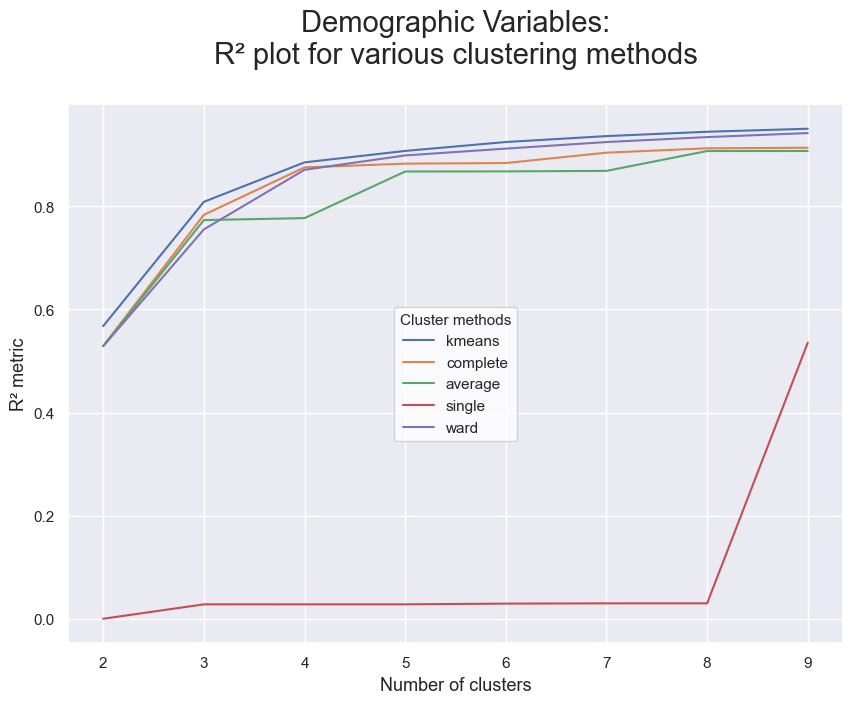

In [8]:
# Visualizing the R² scores for each cluster solution on behavior variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

sns.set_style("whitegrid")
plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.grid(True)
plt.show()

<hr>
<a class="anchor" id="r2pref">
    
## 3.2 R<sup>2</sup> Preference Perspective Clustering

In [9]:
# Obtaining the R² scores for each cluster solution on pref features
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_pref, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_pref, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.391967,0.364212,0.136696,0.000013,0.363947
3,0.670963,0.650897,0.509866,0.000038,0.626761
4,0.813436,0.783840,0.794233,0.000041,0.768659
5,0.864083,0.827721,0.822029,0.000080,0.808909
6,0.889765,0.870032,0.864885,0.000271,0.843643
7,0.907215,0.879332,0.885575,0.000340,0.866972
8,0.920241,0.890562,0.894553,0.000439,0.890080
9,0.932195,0.898509,0.902934,0.000440,0.905722


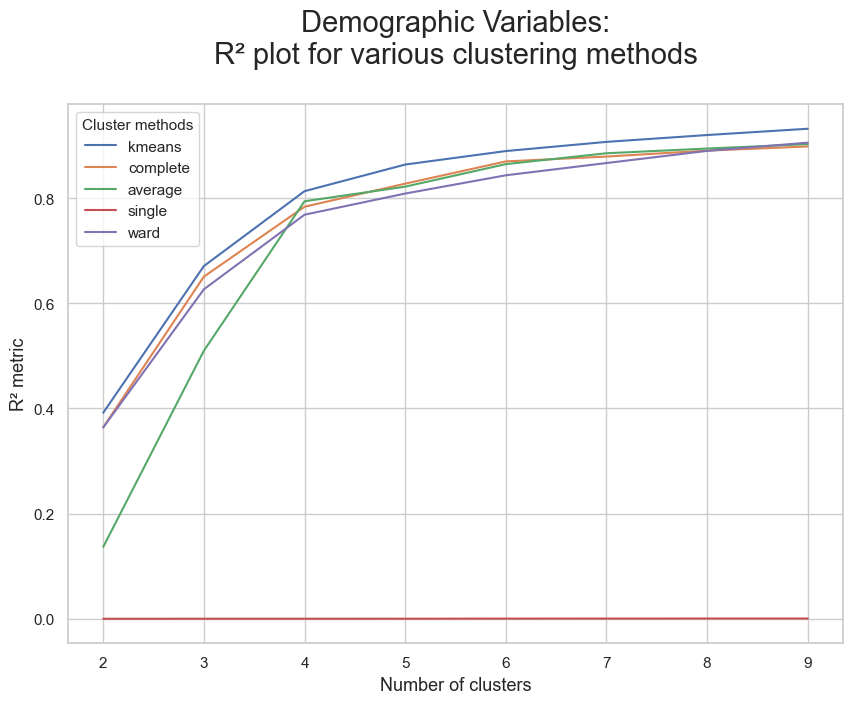

In [10]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

sns.set_style("whitegrid")
plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.grid(True)
plt.show()

<hr>
<a class="anchor" id="kmclustering">
    
# 4. K-means Clustering
    
</a>

In [11]:
def get_ss_variables(df):
    """
    Calculate the sum of squares (SS) for each variable in the DataFrame.
    
    Parameters:
        df (DataFrame): Input DataFrame with numeric columns.
        
    Returns:
        Series: Sum of squares for each column.
    """
    ss_vars = df.var(ddof=0) * (len(df) - 1)  # ddof=0 for population variance
    return ss_vars

def r2_variables(df, labels):
    """
    Calculate the R² for each variable in the DataFrame.
    
    Parameters:
        df (DataFrame): Input DataFrame with numeric columns.
        labels (str or Series): Column or array-like representing labels/groups.
        
    Returns:
        Series: R² value for each variable.
    """
    # Calculate total sum of squares (SST)
    sst_vars = get_ss_variables(df)
    
    # Calculate within-group sum of squares (SSW)
    ssw_vars = df.groupby(labels).apply(get_ss_variables).sum()
    
    # Calculate R² for each variable
    r2_values = 1 - (ssw_vars / sst_vars)
    return r2_values

<hr>
<a class="anchor" id="kmbeh">
    
## 4.1 Behavior Features

#### Defining the number of clusters

In [12]:
range_clusters = range(1, 11)

In [13]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=50, random_state=202)
    kmclust.fit(df_beh)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

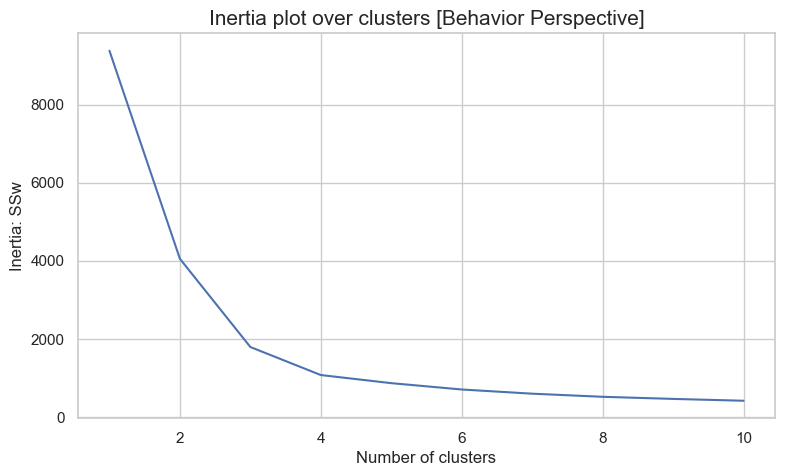

In [14]:
# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters [Behavior Perspective]", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5058480446714886
For n_clusters = 3, the average silhouette_score is : 0.5793925484087795
For n_clusters = 4, the average silhouette_score is : 0.5659899456516448
For n_clusters = 5, the average silhouette_score is : 0.5429367615099004
For n_clusters = 6, the average silhouette_score is : 0.5355471134390828
For n_clusters = 7, the average silhouette_score is : 0.5266852598264343
For n_clusters = 8, the average silhouette_score is : 0.5320357282375103
For n_clusters = 9, the average silhouette_score is : 0.5172153499824941
For n_clusters = 10, the average silhouette_score is : 0.5242083517306906


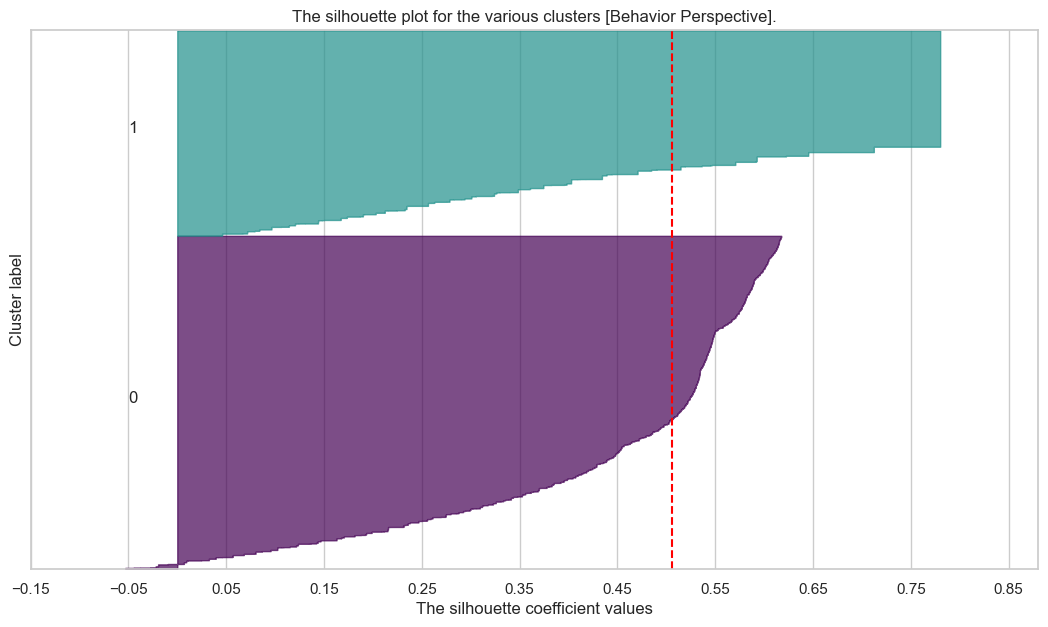

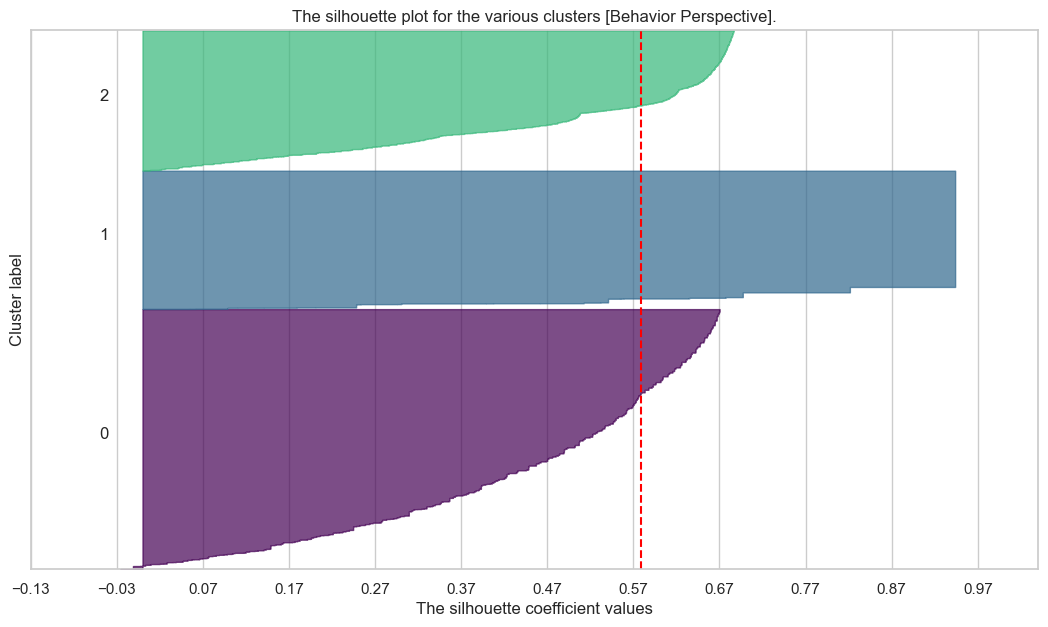

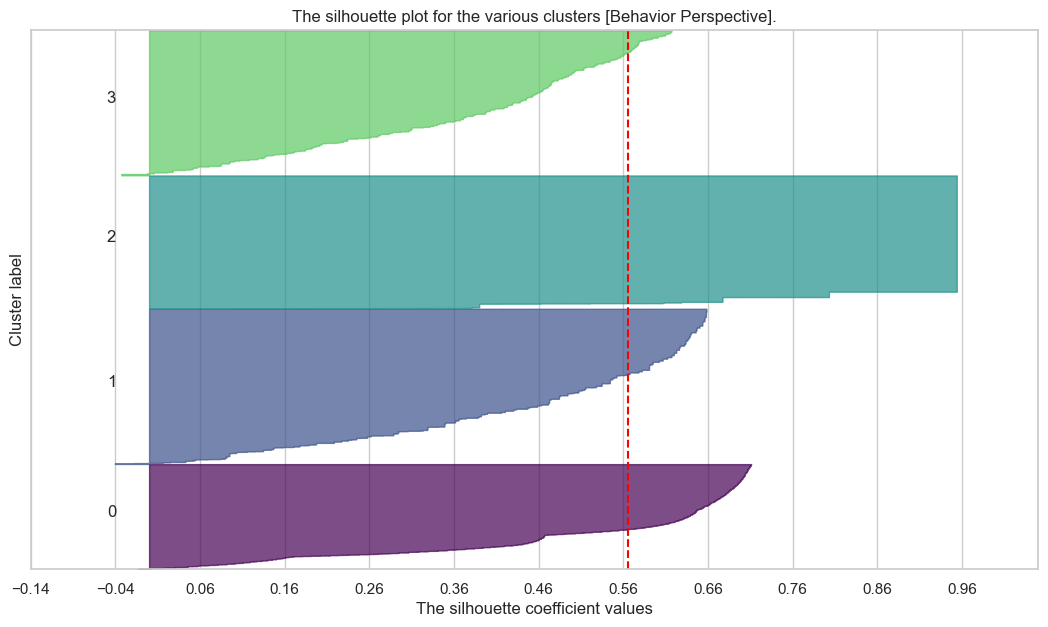

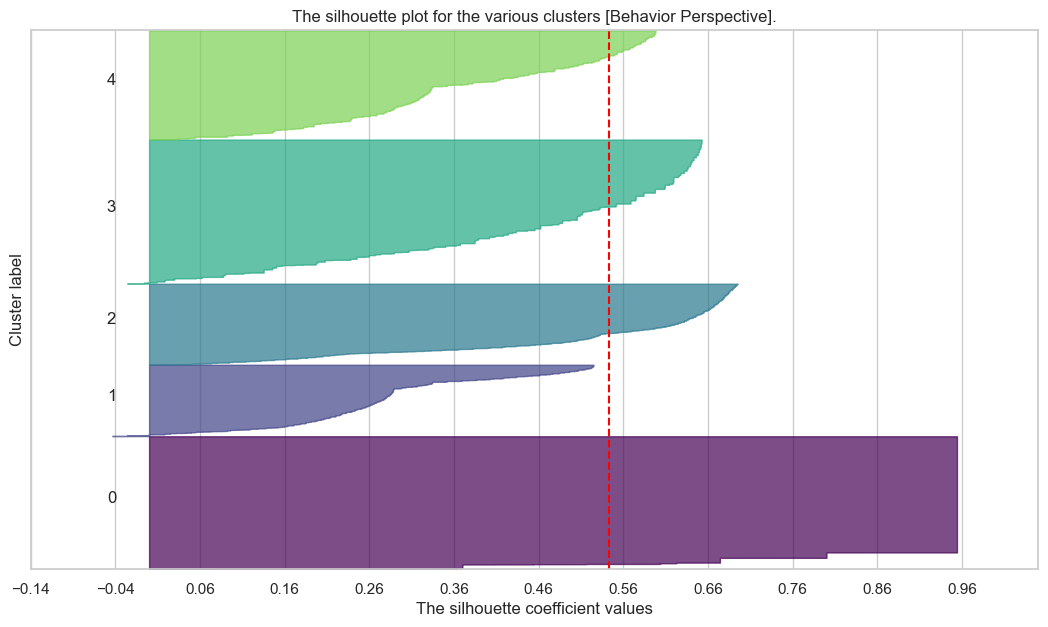

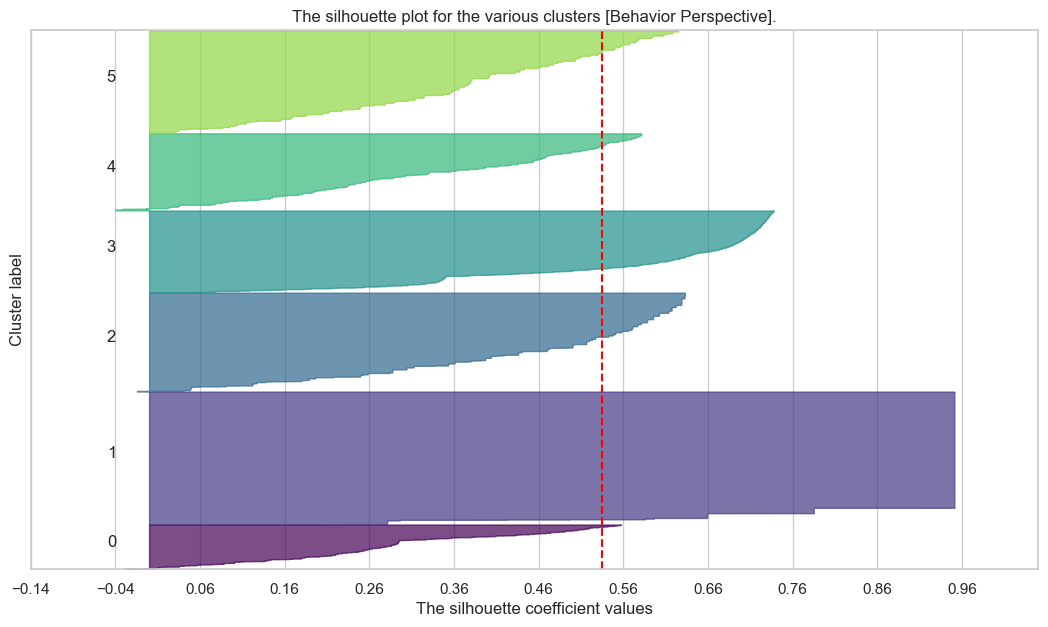

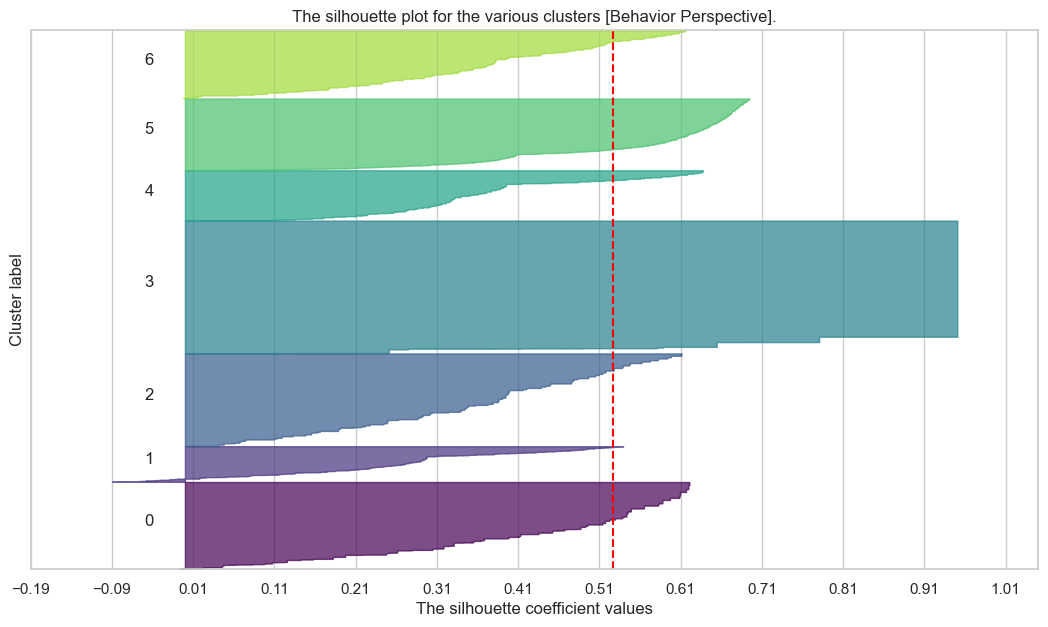

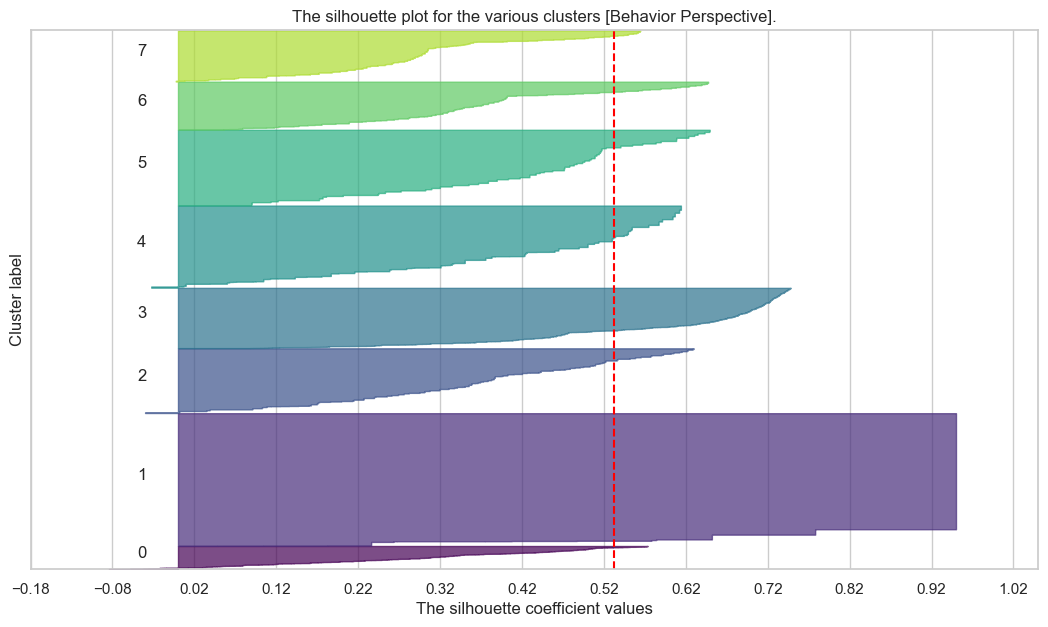

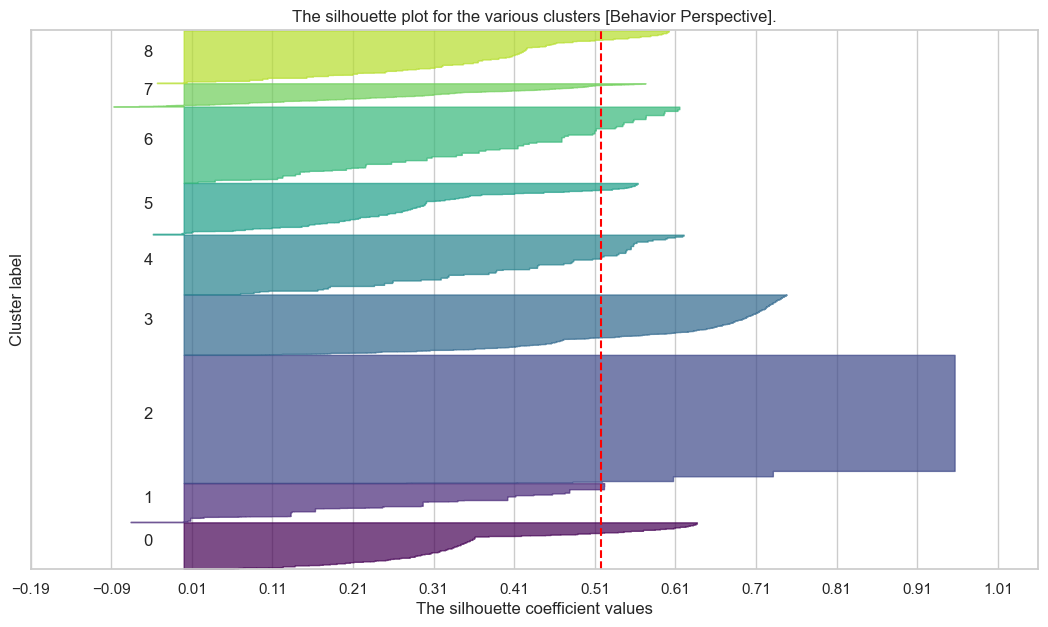

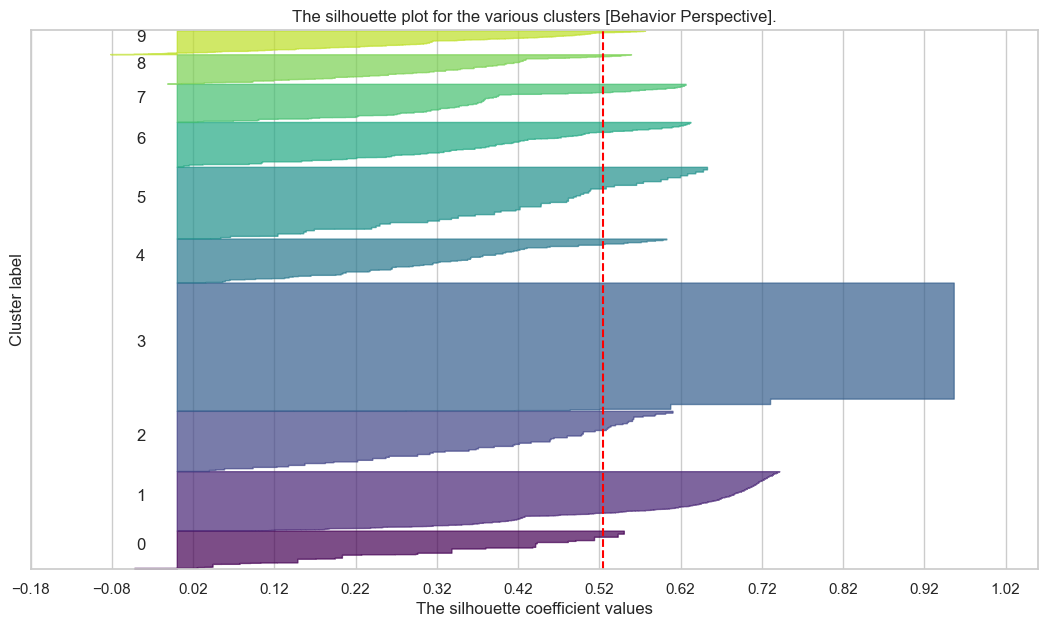

In [15]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=50, random_state=202)
    cluster_labels = kmclust.fit_predict(df_beh)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_beh, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_beh, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.viridis(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    sns.set_style("whitegrid")
    plt.title("The silhouette plot for the various clusters [Behavior Perspective].")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_beh) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

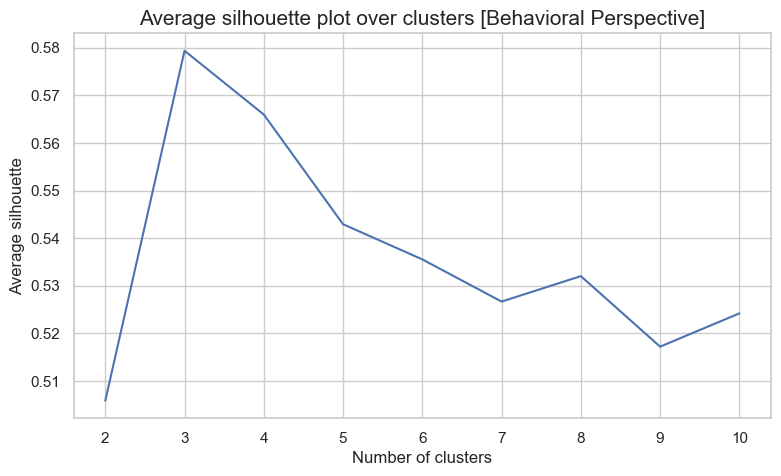

In [16]:
# The average silhouette plot
# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters [Behavioral Perspective]", size=15)
plt.show()

In [17]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km3_labels1 = kmclust.fit_predict(df_beh)
km3_labels1

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [18]:
type(df.columns)

pandas.core.indexes.base.Index

In [19]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km3_labels1, name='beh_labels3', index=df.index)), axis=1)
cluster_means = df_concat.groupby('beh_labels3').mean()[behavior_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1, cmap='viridis')


beh_labels3,0,1,2
Total_Orders,0.25,0.03,0.81
Frequency,0.07,0.71,0.09
Time_with_us,0.40,0.00,0.77


In [20]:
# check how many observations in each cluster
df_concat['beh_labels3'].value_counts()

beh_labels3
0    15327
2     8260
1     8150
Name: count, dtype: int64

In [21]:
label_column = df_concat['beh_labels3']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_beh, label_column)

# Display or return R² results
print(r2_result)

Total_Orders    0.805675
Frequency       0.930971
Time_with_us    0.718017
dtype: float64


In [22]:
# print r_2 results in descending order
r2_result.sort_values(ascending=False)

Frequency       0.930971
Total_Orders    0.805675
Time_with_us    0.718017
dtype: float64

In [23]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km4_labels1 = kmclust.fit_predict(df_beh)
km4_labels1

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [24]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km4_labels1, name='beh_labels4', index=df.index)), axis=1)
cluster_means = df_concat.groupby('beh_labels4').mean()[behavior_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1, cmap='viridis')

beh_labels4,0,1,2,3
Total_Orders,0.90,0.21,0.02,0.35
Frequency,0.11,0.11,0.72,0.03
Time_with_us,0.78,0.23,0.00,0.64


In [25]:
# check how many observations in each cluster
df_concat['beh_labels4'].value_counts()

beh_labels4
1    9153
3    8544
2    7850
0    6190
Name: count, dtype: int64

In [26]:
label_column = df_concat['beh_labels4']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_beh, label_column)

# Display or return R² results
print(r2_result)

Total_Orders    0.860931
Frequency       0.944808
Time_with_us    0.863904
dtype: float64


In [27]:
number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km5_labels1 = kmclust.fit_predict(df_beh)
km5_labels1

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [28]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km5_labels1, name='beh_labels5', index=df.index)), axis=1)
cluster_means = df_concat.groupby('beh_labels5').mean()[behavior_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1, cmap='viridis')

beh_labels5,0,1,2,3,4
Total_Orders,0.02,0.26,0.96,0.60,0.21
Frequency,0.72,0.02,0.12,0.07,0.11
Time_with_us,0.00,0.63,0.81,0.64,0.22


In [29]:
# check how many observations in each cluster
df_concat['beh_labels5'].value_counts()

beh_labels5
4    8494
0    7836
1    6429
2    4774
3    4204
Name: count, dtype: int64

In [30]:
label_column = df_concat['beh_labels5']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_beh, label_column)

# Display or return R² results
print(r2_result)

Total_Orders    0.921456
Frequency       0.946668
Time_with_us    0.863336
dtype: float64


In [31]:
# print r^2 results in descending order
r2_result.sort_values(ascending=False)

Frequency       0.946668
Total_Orders    0.921456
Time_with_us    0.863336
dtype: float64

<hr>
<a class="anchor" id="kmpref">
    
## 4.2 Preference Features

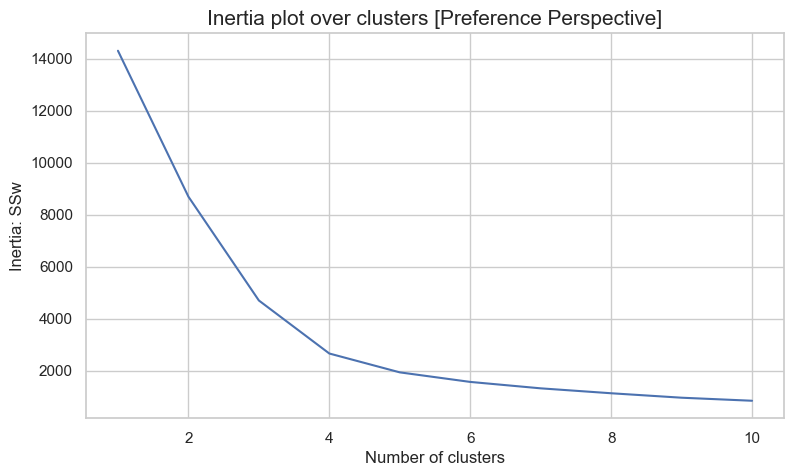

In [32]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_pref)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters [Preference Perspective]", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.4123138119864409
For n_clusters = 3, the average silhouette_score is : 0.541824011616025
For n_clusters = 4, the average silhouette_score is : 0.6070760912657189
For n_clusters = 5, the average silhouette_score is : 0.5688753457914272
For n_clusters = 6, the average silhouette_score is : 0.5757823035534865
For n_clusters = 7, the average silhouette_score is : 0.5592992085823499
For n_clusters = 8, the average silhouette_score is : 0.5849195223687441
For n_clusters = 9, the average silhouette_score is : 0.5882892878753301
For n_clusters = 10, the average silhouette_score is : 0.6059553188968948


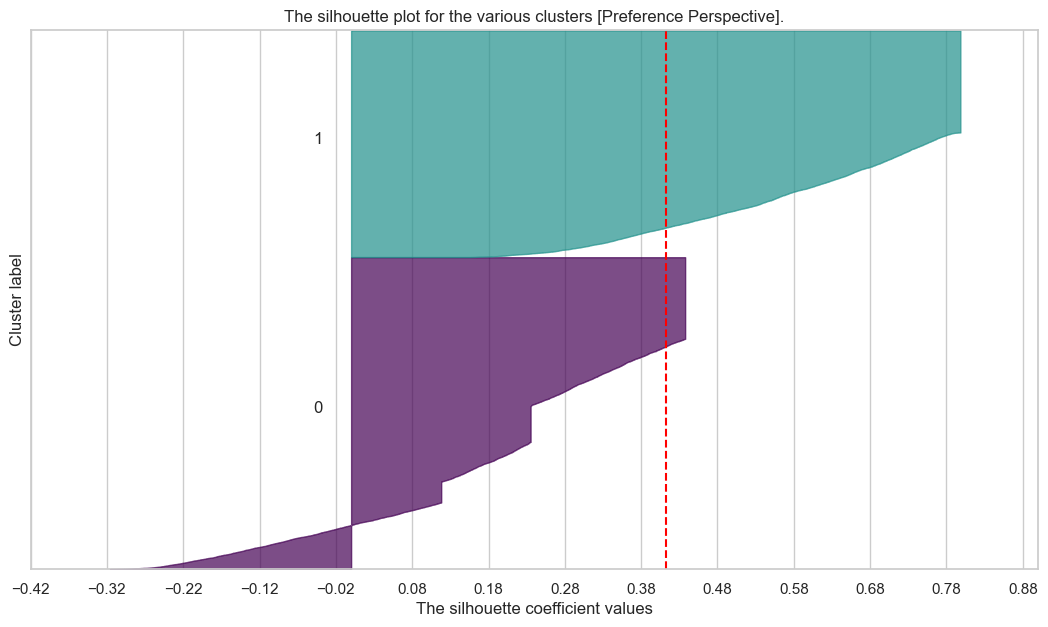

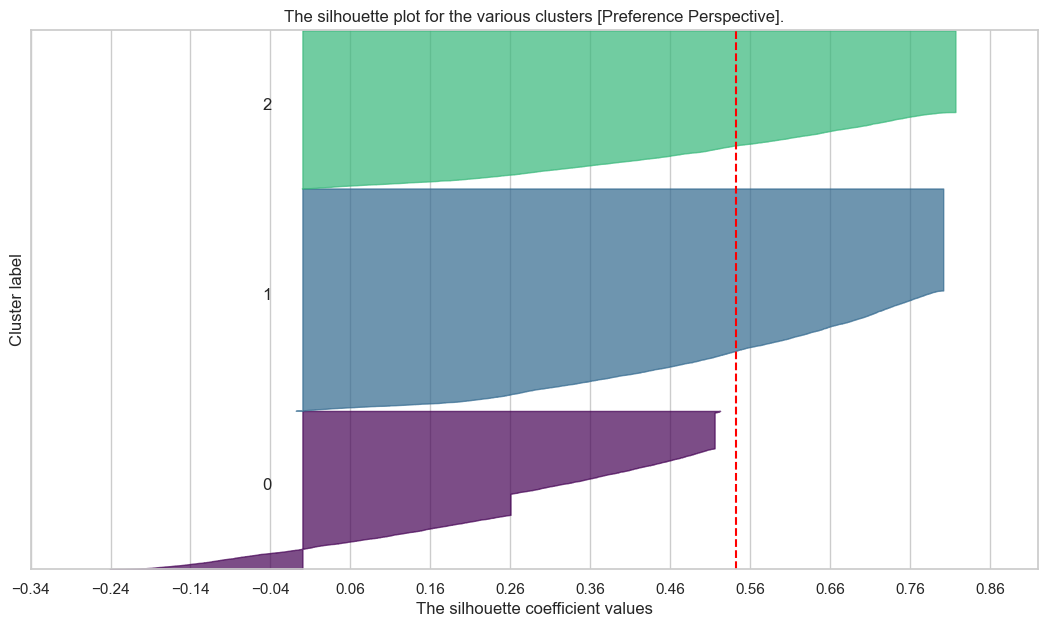

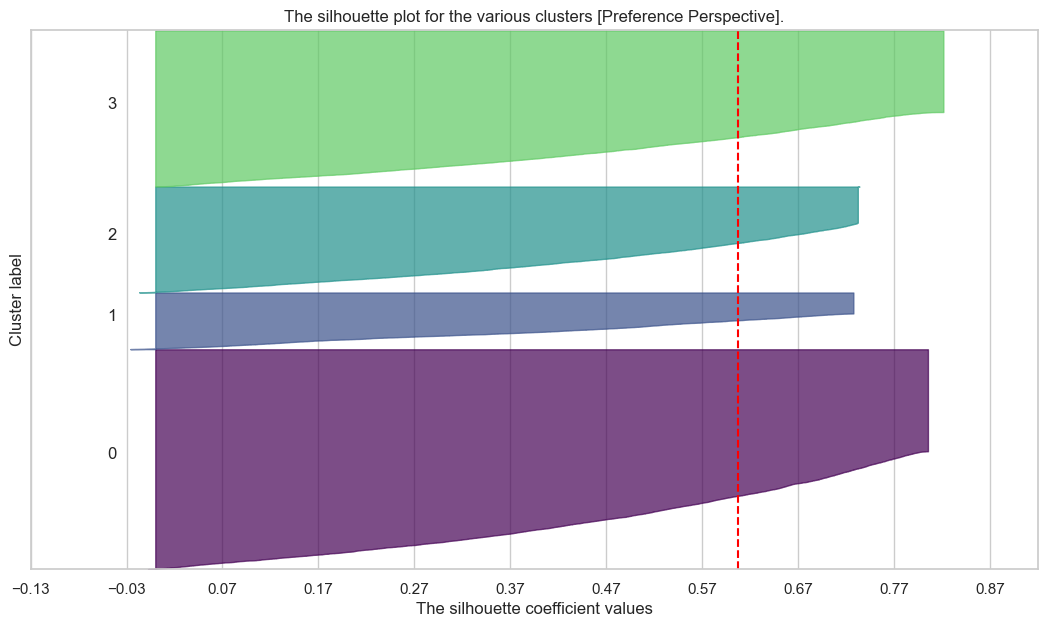

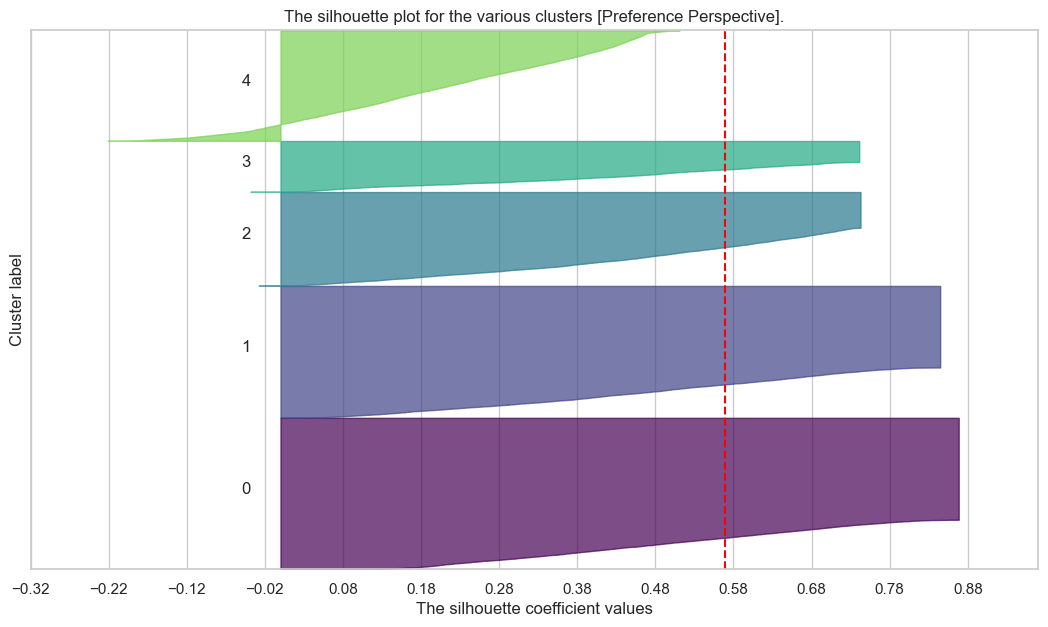

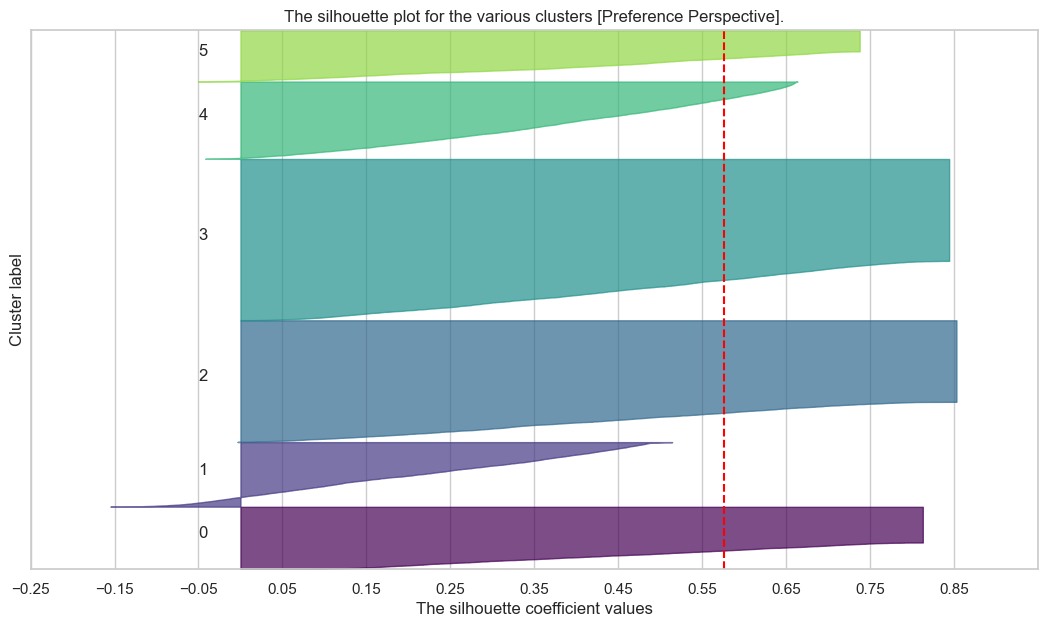

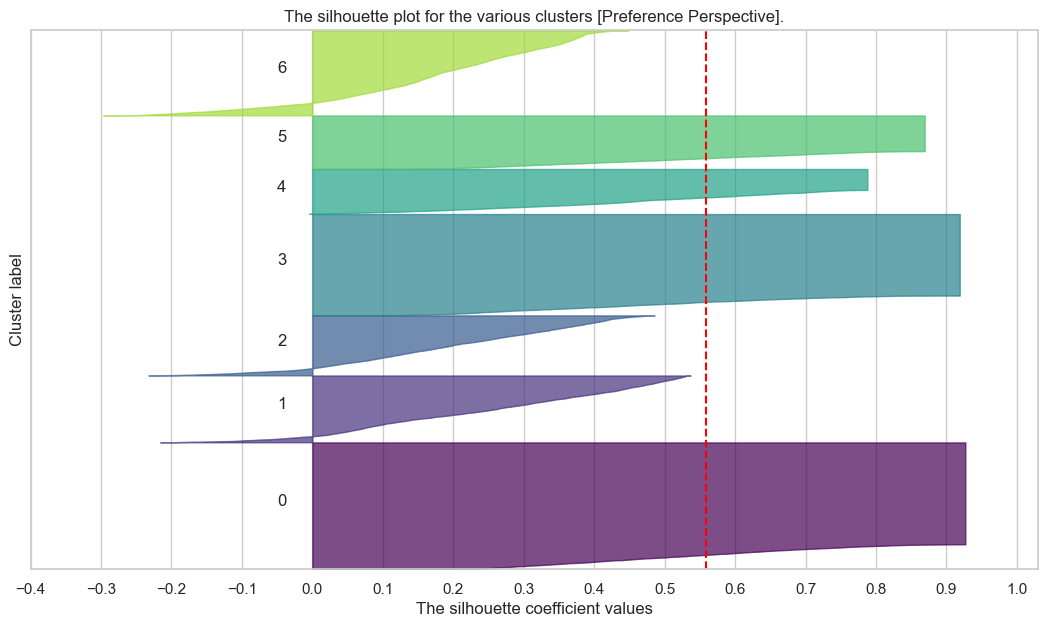

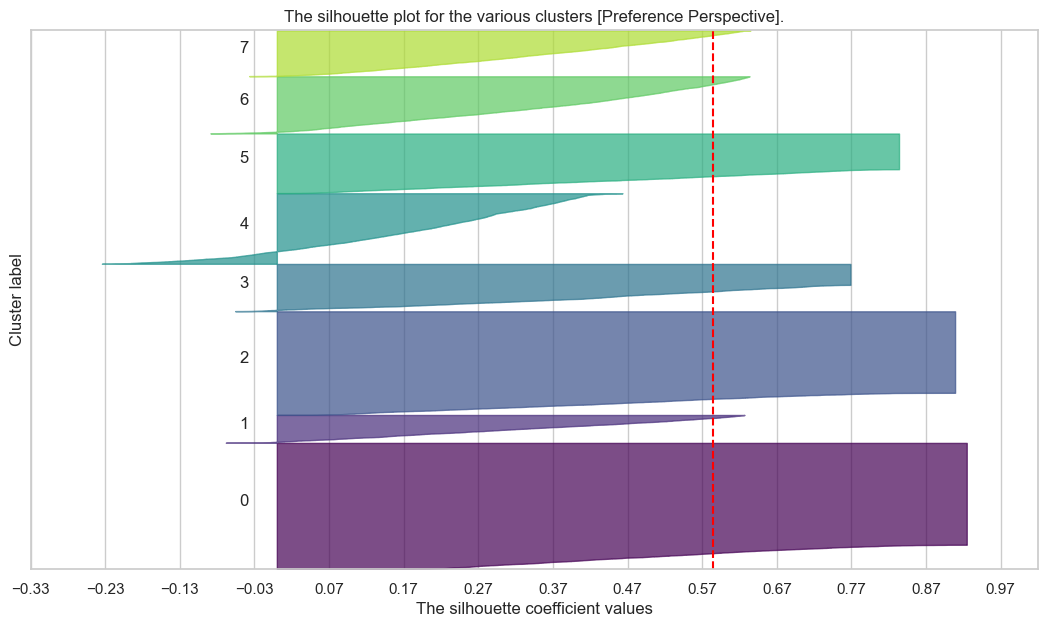

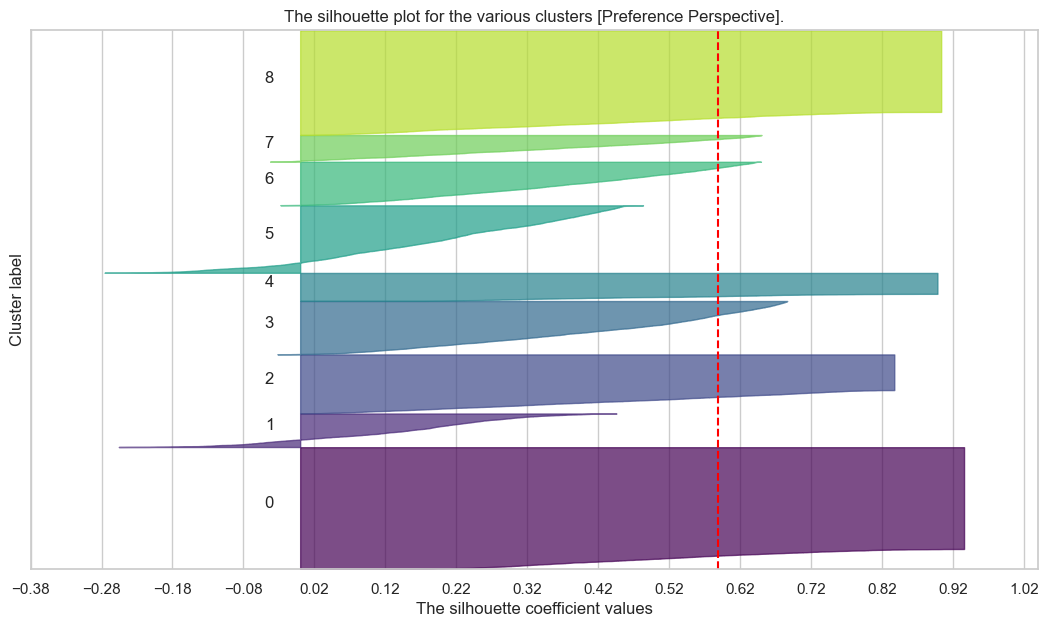

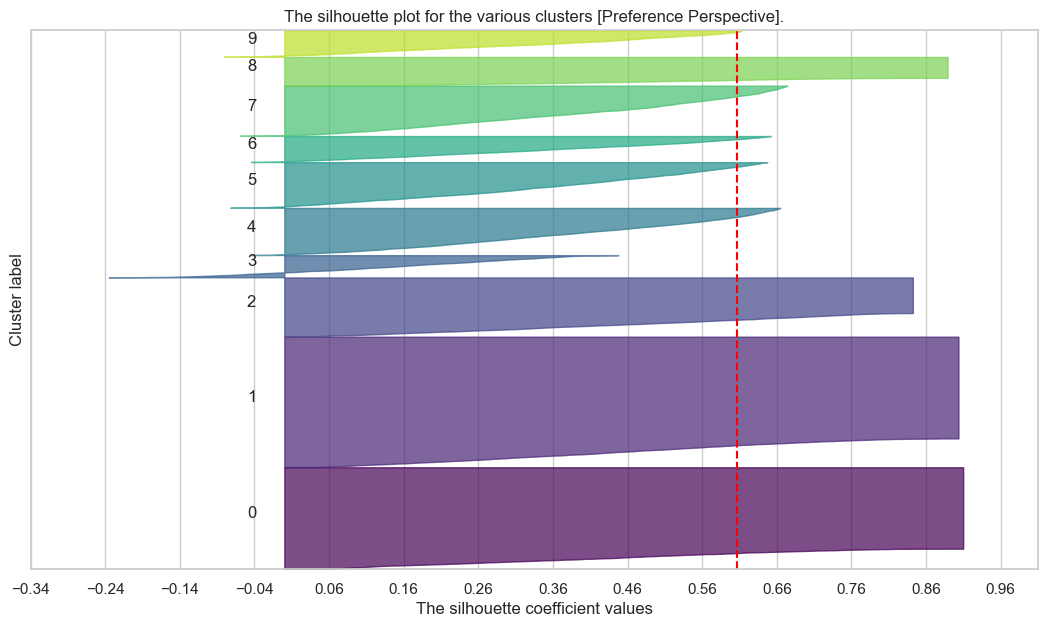

In [33]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=50, random_state=202)
    cluster_labels = kmclust.fit_predict(df_pref)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_pref, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pref, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.viridis(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    sns.set_style("whitegrid")
    plt.title("The silhouette plot for the various clusters [Preference Perspective].")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_pref) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

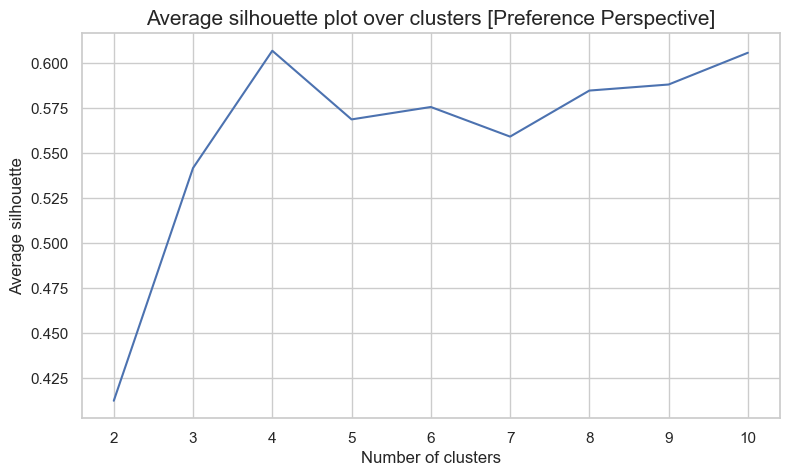

In [34]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis;
         avg_silhouette)     ## Plot Y-axis

sns.set_style("whitegrid")
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters [Preference Perspective]", size=15)
plt.show()

In [35]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km3_labels3 = kmclust.fit_predict(df_pref)
km3_labels3

array([0, 2, 2, ..., 1, 0, 2], dtype=int32)

In [36]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km3_labels3, name='pref_labels3', index=df.index)), axis=1)
cluster_means = df_concat.groupby('pref_labels3').mean()[preferences_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1,cmap='viridis')

pref_labels3,0,1,2
Asian_Proportion,0.83,0.12,0.10
Western_Proportion,0.09,0.08,0.83
Drinks_desserts_Proportion,0.04,0.27,0.03
Specific_other_Proportion,0.04,0.53,0.03


In [37]:
# check how many observations in each cluster
df_concat['pref_labels3'].value_counts()

pref_labels3
0    13085
2     9332
1     9320
Name: count, dtype: int64

In [38]:
label_column = df_concat['pref_labels3']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_pref, label_column)

# Display or return R² results
print(r2_result)

Asian_Proportion              0.810388
Western_Proportion            0.826677
Drinks_desserts_Proportion    0.188315
Specific_other_Proportion     0.518750
dtype: float64


In [39]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km4_labels3 = kmclust.fit_predict(df_pref)
km4_labels3

array([0, 3, 3, ..., 1, 0, 3], dtype=int32)

In [40]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km4_labels3, name='pref_labels4', index=df.index)), axis=1)
cluster_means = df_concat.groupby('pref_labels4').mean()[preferences_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1,cmap='viridis')

pref_labels4,0,1,2,3
Asian_Proportion,0.83,0.12,0.13,0.10
Western_Proportion,0.09,0.08,0.08,0.84
Drinks_desserts_Proportion,0.03,0.74,0.04,0.02
Specific_other_Proportion,0.05,0.06,0.75,0.04


In [41]:
# check how many observations in each cluster
df_concat['pref_labels4'].value_counts()

pref_labels4
0    12962
3     9199
2     6237
1     3339
Name: count, dtype: int64

In [42]:
label_column = df_concat['pref_labels4']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_pref, label_column)

# Display or return R² results
print(r2_result)

Asian_Proportion              0.809338
Western_Proportion            0.825944
Drinks_desserts_Proportion    0.793240
Specific_other_Proportion     0.814257
dtype: float64


In [43]:
# print r^2 results in descending order
r2_result.sort_values(ascending=False)

Western_Proportion            0.825944
Specific_other_Proportion     0.814257
Asian_Proportion              0.809338
Drinks_desserts_Proportion    0.793240
dtype: float64

In [44]:
number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km5_labels3 = kmclust.fit_predict(df_pref)
km5_labels3

array([2, 1, 1, ..., 3, 2, 1], dtype=int32)

In [45]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km5_labels3, name='pref_labels5', index=df.index)), axis=1)
cluster_means = df_concat.groupby('pref_labels5').mean()[preferences_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1,cmap='viridis')

pref_labels5,0,1,2,3,4
Asian_Proportion,0.51,0.05,0.94,0.09,0.09
Western_Proportion,0.29,0.90,0.02,0.07,0.08
Drinks_desserts_Proportion,0.08,0.02,0.02,0.78,0.04
Specific_other_Proportion,0.13,0.03,0.02,0.05,0.79


In [46]:
# check how many observations in each cluster
df_concat['pref_labels5'].value_counts()

pref_labels5
2    8895
1    7785
0    6527
4    5536
3    2994
Name: count, dtype: int64

In [47]:
label_column = df_concat['pref_labels5']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_pref, label_column)

# Display or return R² results
print(r2_result)

Asian_Proportion              0.904315
Western_Proportion            0.868350
Drinks_desserts_Proportion    0.805738
Specific_other_Proportion     0.829704
dtype: float64


## Merging the Perspectives

In [48]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_beh = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=50,
    random_state=202
)
beh_labels = kmeans_beh.fit_predict(df_beh)


kmeans_pref = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=50,
    random_state=202
)
pref_labels = kmeans_pref.fit_predict(df_pref)

df['beh_labels'] = beh_labels
df['pref_labels'] = pref_labels

In [49]:
df['merged_labels']=df['beh_labels'].astype(str) + df['pref_labels'].astype(str)
df['merged_labels']

0        00
1        03
2        03
3        00
4        00
         ..
31732    01
31733    03
31734    01
31735    00
31736    03
Name: merged_labels, Length: 31737, dtype: object

In [50]:
# display number of observations in each cluster of each perspective
#df['beh_labels'].value_counts(), 
df['beh_labels'].value_counts(), df['pref_labels'].value_counts(), df['merged_labels'].value_counts()

(beh_labels
 3    8493
 0    7836
 4    6429
 2    4772
 1    4207
 Name: count, dtype: int64,
 pref_labels
 0    12962
 3     9199
 2     6237
 1     3339
 Name: count, dtype: int64,
 merged_labels
 30    3450
 00    3182
 40    2571
 03    2497
 33    2484
 20    2006
 43    1925
 10    1753
 32    1588
 02    1295
 42    1233
 22    1201
 13    1176
 23    1117
 31     971
 12     920
 01     862
 41     700
 21     448
 11     358
 Name: count, dtype: int64)

In [51]:
# Map each unique label from merged_labels to NUMBERS from 1 to len(unique_labels)
label_mapping = {label: i for i, label in enumerate(df['merged_labels'].unique())}
df['merged_labels'] = df['merged_labels'].map(label_mapping)

In [52]:
# how many disitinct clusters
df['merged_labels'].nunique()

20

In [53]:
# groupby the merged_labels and [behavior_features] + preferences_features to get the mean of each cluster
final_clusters = df.groupby('merged_labels')[behavior_features + preferences_features].mean()
final_clusters.style.format(precision=2).background_gradient(axis=1,cmap='viridis')

,Total_Orders,Frequency,Time_with_us,Asian_Proportion,Western_Proportion,Drinks_desserts_Proportion,Specific_other_Proportion
merged_labels,,,,,,,
0,0.02,0.72,0.00,0.98,0.01,0.00,0.00
1,0.02,0.72,0.00,0.01,0.98,0.00,0.00
2,0.02,0.73,0.00,0.02,0.01,0.97,0.01
3,0.02,0.72,0.00,0.02,0.01,0.01,0.97
4,0.20,0.11,0.22,0.84,0.09,0.03,0.04
5,0.20,0.11,0.22,0.11,0.83,0.03,0.03
6,0.22,0.11,0.22,0.11,0.08,0.03,0.77
7,0.20,0.11,0.21,0.12,0.09,0.74,0.05
8,0.60,0.07,0.63,0.73,0.15,0.05,0.07


## Cluster visualization using t-SNE

In [54]:
df_to_visualize = df[[  'Total_Orders', 'Frequency', 'Time_with_us', 'Asian_Proportion', 'Western_Proportion', 'Drinks_desserts_Proportion', 'Specific_other_Proportion', #'merged_labels'
                      ]] 

In [55]:
from sklearn.manifold import TSNE
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df_to_visualize)

In [56]:
df.columns

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'Total_Orders', 'Total_Spent',
       'Spent_Per_Order', 'Items_Per_Order', 'Frequency', 'Loyalty',
       'Time_with_us', 'CUI_diversity', 'Night', 'Day', 'Dinner', 'Weekdays',
       'Weekends', 'Asian', 'Western', 'Drinks_desserts', 'Specific_other',
       'CUI_cat_diversity', 'Promo', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3',
       'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4',
       'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12',
       'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20',
       'HR_21', 'HR_22', 'HR_23', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai',
       'Asian_Proportion', 'Western_Proporti

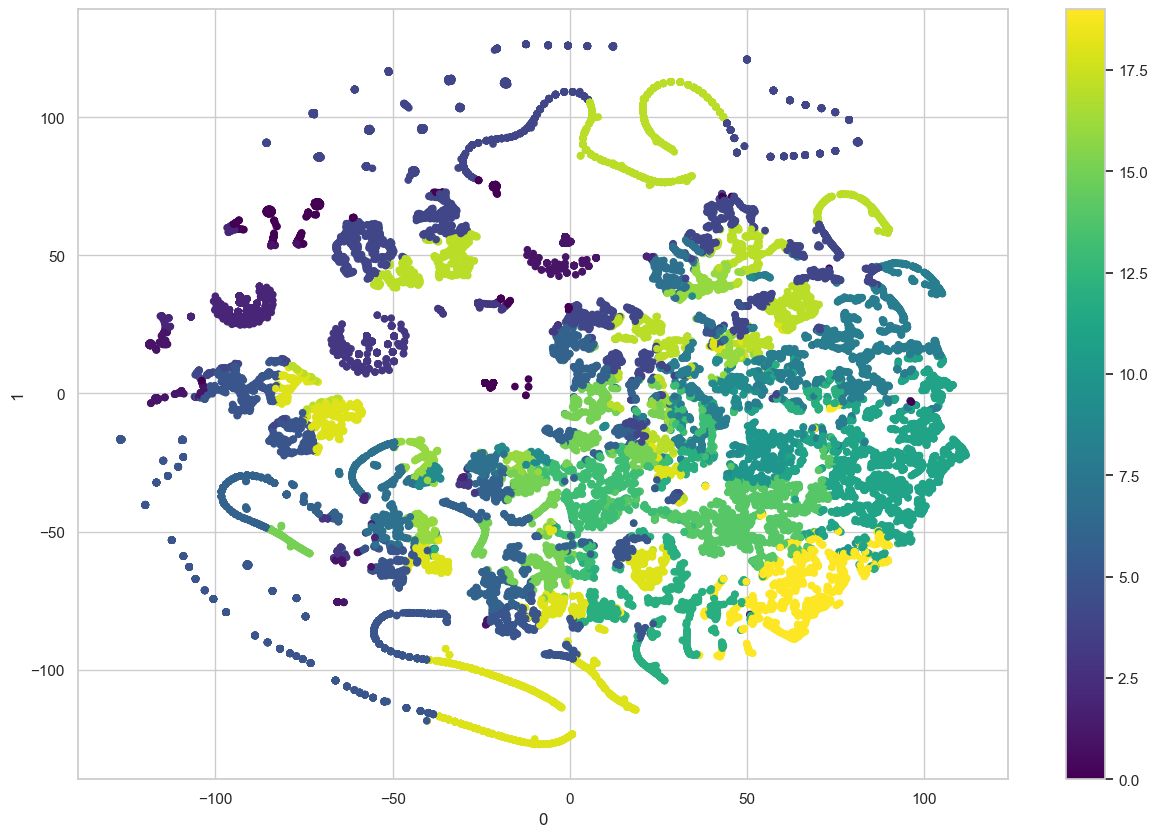

In [57]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='viridis', figsize=(15,10))
plt.show()

In [58]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [60]:
metric_features = df.select_dtypes(include=['number']).columns


In [61]:
metric_features

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'Total_Orders', 'Total_Spent',
       'Spent_Per_Order', 'Items_Per_Order', 'Frequency', 'Loyalty',
       'Time_with_us', 'CUI_diversity', 'Night', 'Day', 'Dinner', 'Weekdays',
       'Weekends', 'Asian', 'Western', 'Drinks_desserts', 'Specific_other',
       'CUI_cat_diversity', 'Promo', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3',
       'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4',
       'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12',
       'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20',
       'HR_21', 'HR_22', 'HR_23', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle_Dishes', 'CUI_OTHER', 'CUI_Street_Food/Snacks', 'CUI_Thai',
       'Asian_Proportion', 'Western_Proporti

In [62]:
df['beh_labels'].unique()

array([0, 3, 1, 2, 4], dtype=int32)

In [63]:
print(df['beh_labels'].dtype)

int32


ValueError: Grouper for 'beh_labels' not 1-dimensional

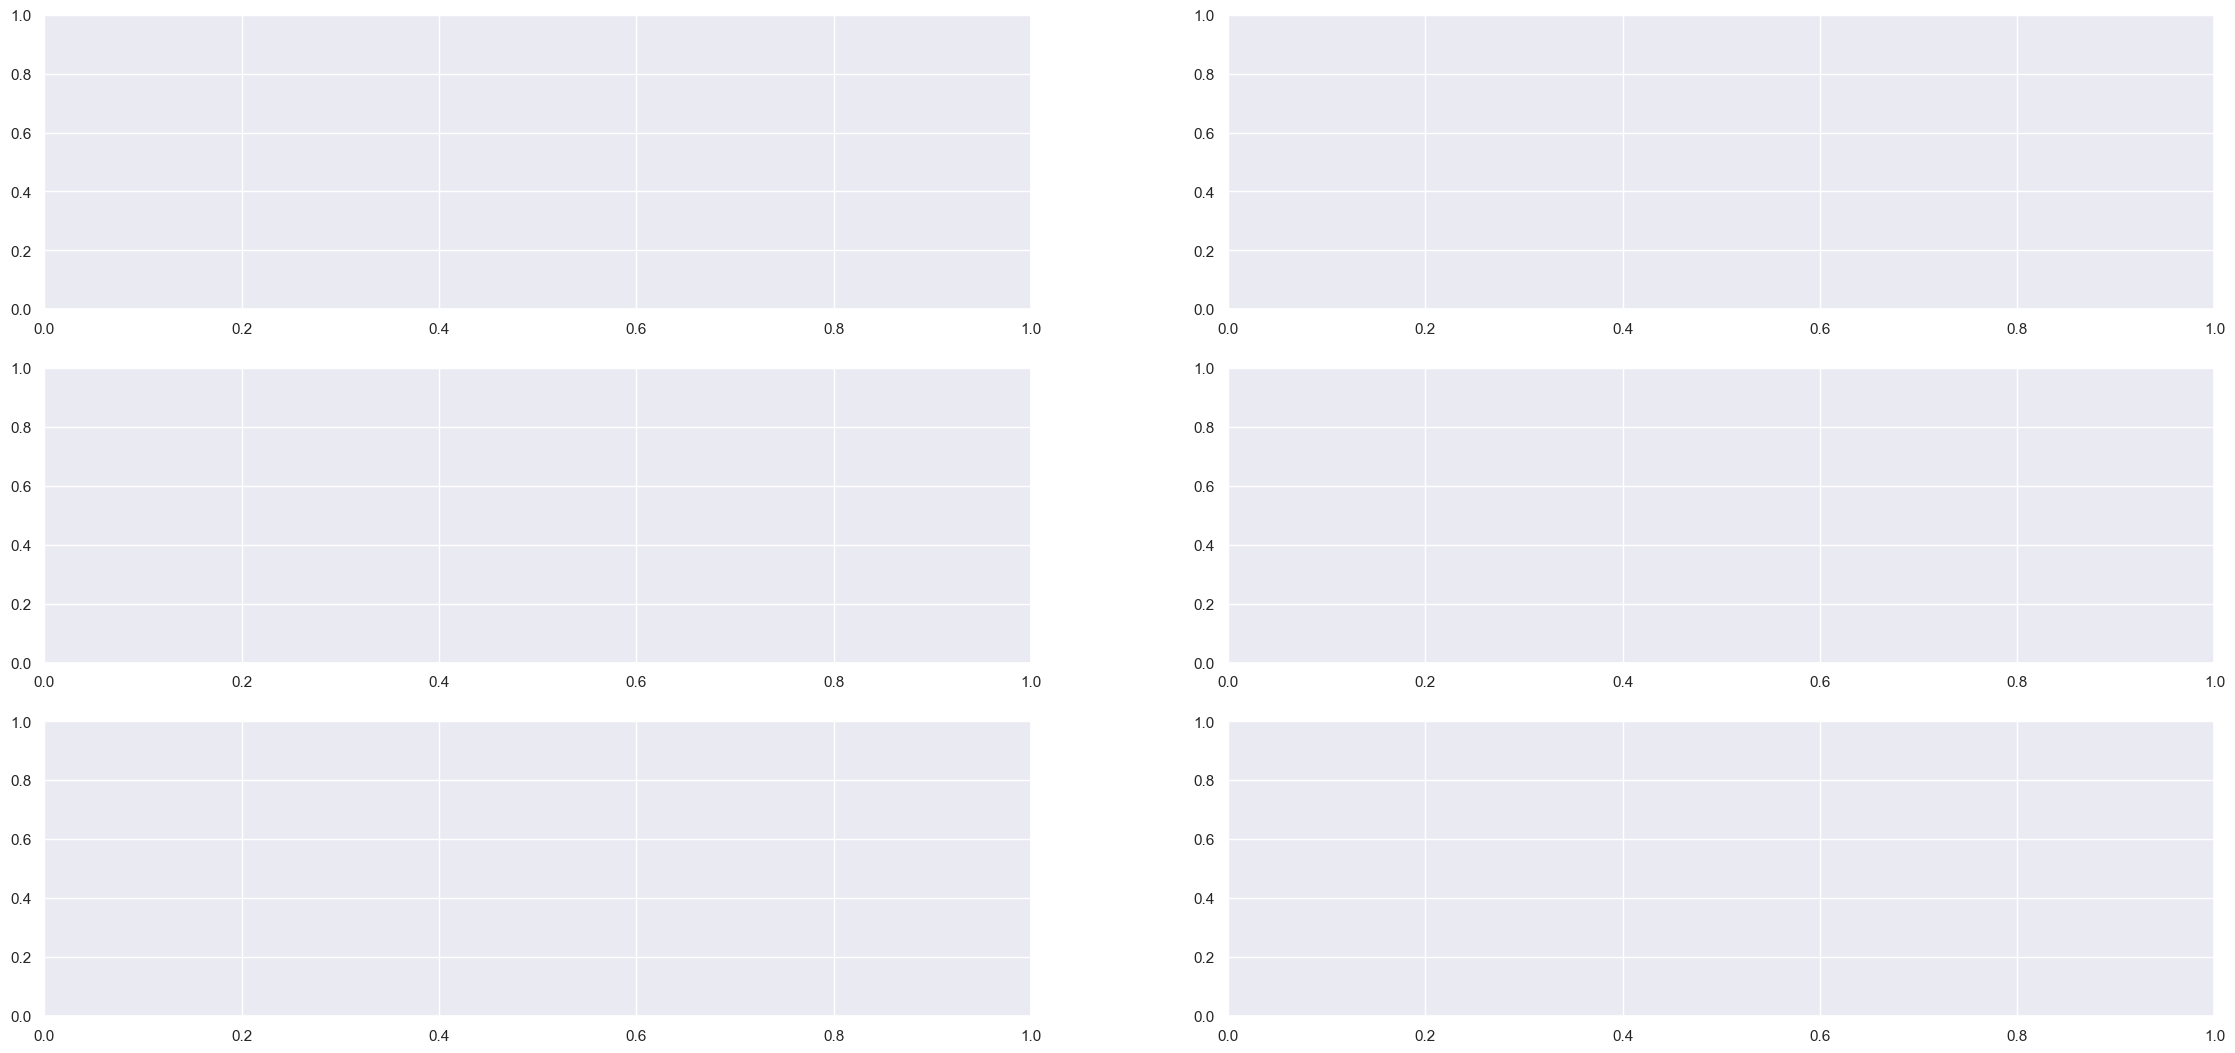

In [64]:
# Profilling each cluster (beh, pref, merged)
cluster_profiles(
    df = df[metric_features.to_list() + ['beh_labels', 'pref_labels', 'merged_labels']], 
    label_columns = ['beh_labels', 'pref_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["beh clustering", "pref clustering", "Merged clusters"]
)

In [ ]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features.to_list() + ['merged_labels']], 'merged_labels').drop('merged_labels')

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

# Preparing the data
X = df.drop(columns=['beh_labels','pref_labels','merged_labels'])
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

In [ ]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns)

#print the feature importance from highest to lowest
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)